In [1]:
import torch
import time
from snn_delays.snn import SNN
from snn_delays.utils.dataset_loader import DatasetLoader
from snn_delays.utils.train_utils import get_device, print_spike_info, propagate_batch, set_seed
from snn_delays.utils.visualization_utils import plot_raster
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Subset, DataLoader
from collections import OrderedDict
device = get_device()

# for reproducibility
set_seed(42)

c:\Users\Alberto\anaconda3\envs\deepsnn\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on: cuda:0


In [3]:
dataset = 'ibm_gestures'
total_time = 100
batch_size = 20

# DATASET
DL = DatasetLoader(dataset=dataset,
                  caching='memory',
                  num_workers=0,
                  batch_size=batch_size,
                  total_time=total_time,
                  sensor_size_to=64,
                  crop_to=3e6)

_, __, dataset_dict = DL.get_dataloaders()

'''
    classes = [
        "0: Hand clapping",
        "1: Right hand wave",
        "2: Left hand wave",
        "3: Right arm cw",  # clockwise
        "4: Right arm ccw",  # counter-clockwise
        "5: Left arm cw",
        "6: Left arm ccw",
        "7: Arm roll",
        "8: Air drums",
        "9: Air guitar",
        "10: Other gestures",
    ]
'''

target_classes = [1, 3, 8]
test_dataset = DL._dataset.test_dataset
train_dataset = DL._dataset.train_dataset

def filter_by_class(dataset, target_classes):
    indices = [i for i, (img, label) in enumerate(dataset) if np.argmax(label) in target_classes]
    filtered_dataset = torch.utils.data.Subset(dataset, indices)
    return torch.utils.data.DataLoader(filtered_dataset, batch_size=batch_size, shuffle=True)

[CropTime(min=0, max=3000000.0), Downsample(time_factor=1, spatial_factor=0.5, sensor_size=None, target_size=None), ToFrame(sensor_size=(64, 64, 2), time_window=None, event_count=None, n_time_bins=100, n_event_bins=None, overlap=0, include_incomplete=False)]



[INFO] Delays: tensor([0])

[INFO] Delays i: tensor([0])

[INFO] Delays h: tensor([0])

[INFO] Delays o: tensor([0])
1000.0
Delta t: 10.0 ms
mean of normal: 0.4327521295671885
for input layer
total spikes: 1283356.0
spikes per sample: 64167.8
spikes per timestep: 641.68 / 8192
spikes per neuron: 7.83 / 100
spike density: 0.00078329833984375
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


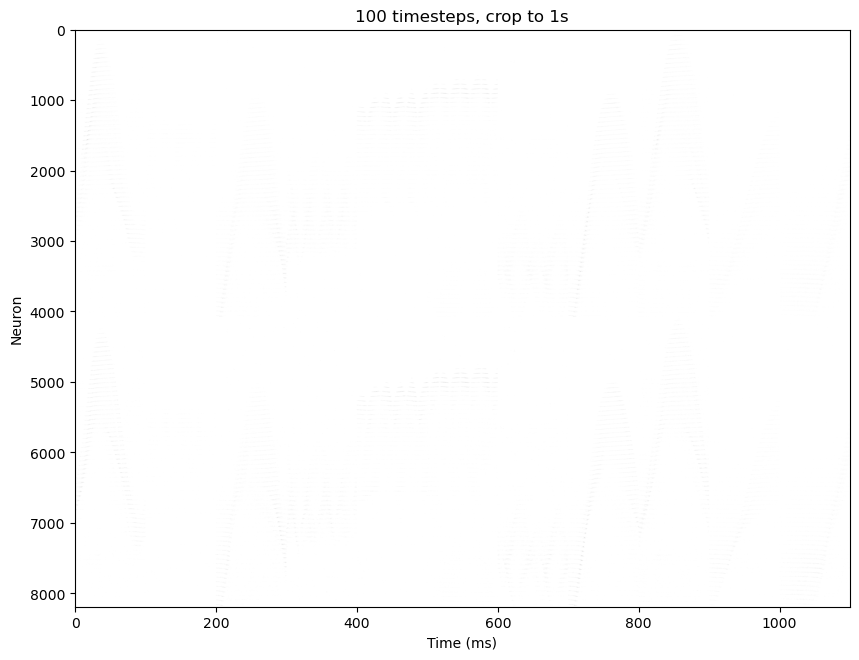

In [ ]:
dataloader = filter_by_class(test_dataset, target_classes)

snn = SNN(dataset_dict=dataset_dict, structure=(256, 2), connection_type='f',
    delay=None, delay_type='ho', tau_m = 'normal',
    win=total_time, loss_fn='mem_sum', batch_size=batch_size, device=device,
    debug=True)

snn.set_network()

_, __ = propagate_batch(snn, dataloader)
print_spike_info(snn, 'input')
plt.figure(figsize=(10,17))
plt.title("100 timesteps, crop to 1s")
plot_raster(snn, 'input', 11)
plt.gca().set_aspect(0.1)

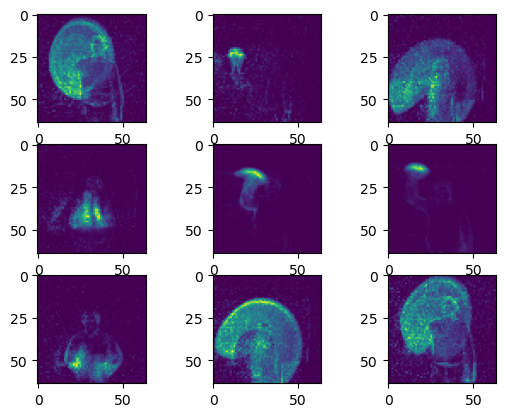

In [11]:
from snn_delays.utils.visualization_utils import frame_2_image
for x in range(9):
    plt.subplot(3,3,x+1)
    plt.imshow(frame_2_image(snn, x))

In [4]:
dataset = test_dataset

indices = [i for i, (img, label) in enumerate(dataset) if np.argmax(label) in target_classes]
filtered_dataset = torch.utils.data.Subset(dataset, indices)



In [18]:
for x, y in filtered_dataset:
    print(x.shape)
    break

(100, 2, 64, 64)


GC- Gesture concatenation

In [22]:
import torch
from torch.utils.data import Dataset, DataLoader
from itertools import product

# Custom dataset for digit concatenation from a filtered dataset
class ConcatenatedDataset(Dataset):
    def __init__(self, base_dataset, sequence_length, target_classes):
        self.base_dataset = base_dataset
        indices = [i for i, (img, label) in enumerate(base_dataset) if np.argmax(label) in target_classes]
        self.filtered_dataset = torch.utils.data.Subset(base_dataset, indices)
        self.indices = list(range(len(filtered_dataset)))  # Indices of the base dataset
        self.target_classes = target_classes
        #self.pairs = [(i, j) for i in self.indices for j in self.indices]  # All possible pairs of indices
        self.sequence_length = sequence_length
        #self.pairs = list(product(self.indices, repeat=sequence_length))
        self.num_classes = len(target_classes)
        self.total_combinations = self.num_classes ** sequence_length

    def __len__(self):
        # Number of pairs
        #return len(self.pairs)
        return len(self.base_dataset)

    def __getitem__(self, idx):
        # Get the indices for the current pair
        #indices = self.pairs[idx]
        # Retrieve the images and labels from the base dataset
        images = []
        labels = []

        for i in range(self.sequence_length):
            img, label = self.filtered_dataset[np.random.choice(self.indices)]
            images.append(img)
            labels.append(self.target_classes.index(np.argmax(label)))
        # Concatenate the images along the width (you can adjust as needed)
        concatenated_img = np.concatenate(images, axis=0)
        
        # Concatenate the labels one-hot
        encoded_label = sum(l * (self.num_classes ** i) for i, l in enumerate(reversed(labels)))
        concatenated_label = torch.zeros(self.total_combinations, dtype=torch.float32)
        concatenated_label[encoded_label] = 1.0

        return concatenated_img, concatenated_label

In [23]:
concatenated_dataset = ConcatenatedDataset(test_dataset, 4, target_classes)

In [24]:
dataloader = DataLoader(concatenated_dataset, batch_size=batch_size, shuffle=True)

In [25]:
for concatenated_imgs, concatenated_labels in dataloader:
    print("Labels:", concatenated_labels)
    print("Image batch shape:", concatenated_imgs.shape)  # Shape should reflect concatenation
    break

Labels: tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
Image batch shape: torch.Size([20, 400, 2, 64, 64])


In [26]:
len(concatenated_dataset)

264


[INFO] Delays: tensor([0])

[INFO] Delays i: tensor([0])

[INFO] Delays h: tensor([0])

[INFO] Delays o: tensor([0])
3000.0
Delta t: 7.5 ms
mean of normal: 0.7874767291801942
for input layer
total spikes: 16154237.0
spikes per sample: 807711.85
spikes per timestep: 2019.28 / 8192
spikes per neuron: 98.6 / 400
spike density: 0.000616235237121582
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


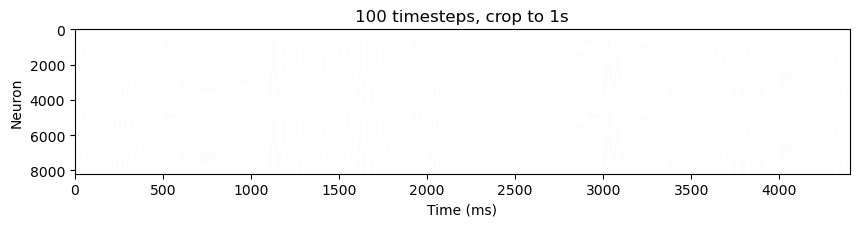

In [27]:
dataset_dict["num_output"] = concatenated_dataset.total_combinations
dataset_dict["num_training_samples"] = len(concatenated_dataset)

snn = SNN(dataset_dict=dataset_dict, structure=(256, 2), connection_type='f',
    delay=None, delay_type='ho', tau_m = 'normal',
    win=total_time*4, loss_fn='mem_sum', batch_size=batch_size, device=device,
    debug=True)

snn.set_network()

_, __ = propagate_batch(snn, dataloader)
print_spike_info(snn, 'input')
plt.figure(figsize=(10,17))
plt.title("100 timesteps, crop to 1s")
plot_raster(snn, 'input', 11)
plt.gca().set_aspect(0.1)

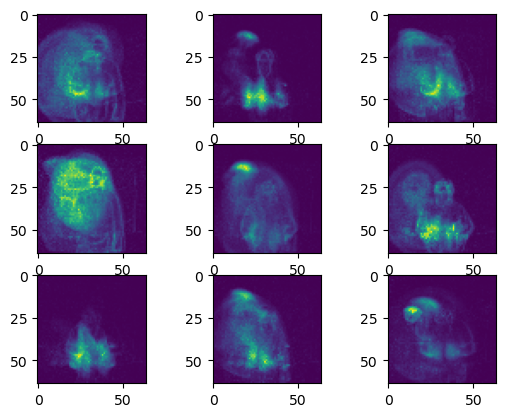

In [29]:
from snn_delays.utils.visualization_utils import frame_2_image
for x in range(9):
    plt.subplot(3,3,x+1)
    plt.imshow(frame_2_image(snn, x))

In [30]:
concatenated_dataset.total_combinations

81

In [31]:
len(filtered_dataset)

72